# E-Commerce Customer Segmentation

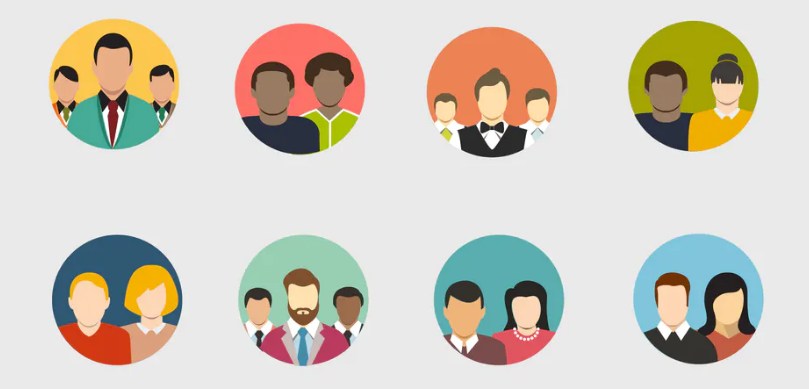

Customer segmentation is an effective tool for businesses to closely align their strategy and tactics with, and better target, their customers. Every customer is different and every customer journey is different so a single approach often isn’t going to work for all. This is where customer segmentation becomes a valuable process.

> Customer segmentation is the process by which you divide your customers into segments up based on common characteristics – such as demographics or behaviors, so you can market to those customers more effectively.

Customer segmentation can be broken down into two types: 
- Segmenting customers based on who they are: the process of understanding who customers are typically focuses on demographics.
- Segmenting customers based on what they do: you can also segment customers based on how much they spend (share of wallet), how often, and what products (this allows you to see how much you can increase spend). This is more behavior focused. **That's the data we have and the kind of segmentation we will do.**


### Research questions
The aim of the study is to answer the below research questions:
- What is the general sales trend?
- What is an average cart by country?
- How often do customers buy products?
- What countries are the most active?
- How many new customers each months?
- What are the best selling products?
- When do customers tend to purchase products?


### About the dataset

Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, The UCI Machine Learning Repository has made this dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail".

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

### Features

1. *InvoiceNo*: An ID to identify the bill
2. *StockCode*: An ID to identify the stock origin
3. *Description*: The product bought
4. *Quantity*: The quantity of the product bought
5. *InvoiceDate*: The date of the transaction
6. *UnitPrice*: The unit price of the product
7. *CustomerID*: The customer ID
8. *Country*: The country where the transaction has been done

---

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Install: seaborn, sklearn

---

## Exploratory Data Analysis

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/julienjta/Data-Science-Portfolio/main/Project%203/data/data.csv",encoding = 'unicode_escape')
print("There are {} observations for {} predictors.".format(df.shape[0],df.shape[1]))
df.head()

There are 541909 observations for 8 predictors.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
